# Libraries

In [1]:
# Import libraries

from os import listdir
import string
import pandas as pd
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import re, string, unicodedata
import contractions
import nltk
import pickle
import inflect
from bs4 import BeautifulSoup
import tensorflow as tf
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


# Loading data

In [3]:
# load doc into memory
def load_doc(filename):
	file = open(filename, encoding='utf-8')
	text = file.read()
	file.close()
	return text

# split a document into news story and highlights
def split_story(doc):
	# find first highlight
	index = doc.find('@highlight')
	# split into story and highlights
	story, highlights = doc[:index], doc[index:].split('@highlight')
	# strip extra white space around each highlight
	highlights = [h.strip() for h in highlights if len(h) > 0]
	return story, highlights

# load all stories in a directory
def load_stories(directory):
    stories = []
    highlights =[]
    for name in listdir(directory)[14000:16001]:
        filename = directory + '/' + name
		# load document
        doc = load_doc(filename)
		# split into story and highlights
        story, highlight = split_story(doc)
		# store
        stories.append(story)
        highlights.append(highlight)
    data = pd.DataFrame()
    data["story"] = stories
    data["highlight"] = highlights
    
    return  data

In [4]:
# load stories
directory = r"C:\Users\feder\Desktop\cnn\stories"
data = load_stories(directory)


In [5]:
print('Loaded Stories %d' % len(data))

Loaded Stories 2001


# Cleaning and preprocessing


In [6]:
data.head()

,story,highlight
0,"(CNN) -- United States President Barack Obama has now paved the way for imposing economic sanctions against Russia. However, these would be an ineffective and naive response by the U.S. to the cri...","[Robert Pape argues economic sanctions against Russia would not work, He argues that while sanctions can hurt a regime, they cannot break it, In many cases, sanctions will make the political situa..."
1,"(EW.com) -- Yes, you read that headline right. We now have proof that Marilyn Monroe was the sexiest woman to ever walk the earth: More than 50 years after her death, people are still willing to s...","[Six facial x-rays of Marilyn Monroe have surfaced, They are marked with the alias name ""Joan Newman"", Executive director of Julien's Auctions says there is still demand for Monroe items]"
2,"(WIRED) -- An anarchist social worker raided by the feds wants his computers, manuscripts and pick axes back. He argues that authorities violated the U.S. Constitution and the rights of his mental...","[Elliott Madison's home is raided by the FBI on October 1, Authorities purportedly look for evidence Madison started a riot on Twitter, Madison challenges the search, saying his rights were violat..."
3,"(CNN) -- The cast of Marvel's ""Avengers: Age of Ultron"" just keeps getting better.\n\nOn Sunday, ""Thor"" co-star Idris Elba let it slip in an interview with the UK's Telegraph that he and Tom Hiddl...","[Idris Elba's confirmed he'll be in ""Avengers: Age of Ultron"", The actor added that Tom Hiddleston will appear in the movie, too, ""Avengers: Age of Ultron"" opens in May]"
4,(CNN) -- British world champion Amir Khan retained his World Boxing Association (WBA) light-welterweight title on Saturday night with a clinical stopppage victory over challenger Paulie Malignaggi...,"[British world champion Amir Khan retains his WBA light-welterweight title, The 23-year-old Khan stops American Paulie Malignaggi in the 11th round, The Madison Square Garden fight marked Khan's b..."


In [7]:
data = data.explode("highlight")

In [8]:
data = data.drop_duplicates(subset="story")

## Normalization

In [9]:
stop_words = set(stopwords.words('english')) 

def remove_non_ascii(words):
    """Remove non-ASCII characters"""
    new_words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase"""
    new_words = words.lower()
    return new_words

def remove_punctuation(words):
    """Remove punctuation"""
    new_words = re.sub(r'\([^)]*\)', '', words)
    return new_words

def replace_numbers(words):
    """Replace all integer occurrences"""
    new_words = re.sub("[^a-zA-Z]", " ", words) 
    return new_words

def remove_stopwords(words):
    """Remove stop words"""
    new_words = [w for w in words.split() if not w in stop_words]
    long_words=[]
    for i in new_words:
        if len(i)>=1:                  
            long_words.append(i)   

    return (" ".join(long_words)).strip()


def replace_contractions(words):
    """Replace contractions in string of text"""
    return contractions.fix(words)

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = replace_contractions(words)
    words = remove_stopwords(words)

    return words

In [10]:
#Call the above function

cleaned_story = []
for t in data['story']:
    cleaned_story.append(normalize(t))

cleaned_highlight = []
for t in data['highlight']:
    cleaned_highlight.append(normalize(t))

data['normalized_text']=cleaned_story
data['normalized_highlight']=cleaned_highlight
data['normalized_highlight'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Lemmatization

In [11]:
def lemmatize(words):
    words = lemmatizer.lemmatize(words)
    return words

In [12]:
#Call the above function

lemmatized_story = []
for t in data['normalized_text']:
    lemmatized_story.append(lemmatize(t))
    
lemmatized_highlight = []
for t in data['normalized_highlight']:
    lemmatized_highlight.append(lemmatize(t))

data['cleaned_text']=lemmatized_story
data['cleaned_highlight']=lemmatized_highlight
data['cleaned_highlight'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Add start and end tokens for the summarizer

In [13]:
data['cleaned_highlight'] = data['cleaned_highlight'].apply(lambda x : 'starttoken '+ x + ' endtoken')


## Visualize results

In [14]:
data = data[["cleaned_text", "cleaned_highlight"]]
data

,cleaned_text,cleaned_highlight
0,united states president barack obama paved way imposing economic sanctions russia however would ineffective naive response crisis ukraine economic sanctions little independent usefulness pursuit n...,starttoken robert pape argues economic sanctions russia would work endtoken
1,yes read headline right proof marilyn monroe sexiest woman ever walk earth years death people still willing spend money facial x rays auctioned julien auctions according vanity fair six facial x r...,starttoken six facial x rays marilyn monroe surfaced endtoken
2,anarchist social worker raided feds wants computers manuscripts pick axes back argues authorities violated constitution rights mentally ill clients searching evidence broke anti rioting law twitte...,starttoken elliott madison home raided fbi october endtoken
3,cast marvel avengers age ultron keeps getting better sunday thor co star idris elba let slip interview uk telegraph tom hiddleston appear next may avengers sequel elba played asgard guardian heimd...,starttoken idris elba confirmed avengers age ultron endtoken
4,british world champion amir khan retained world boxing association light welterweight title saturday night clinical stopppage victory challenger paulie malignaggi madison square garden new york ye...,starttoken british world champion amir khan retains wba light welterweight title endtoken
...,...,...
1996,former president george w bush briefly jumped back national conversation tuesday night interview tonight show bush told host jay leno miss spotlight thoroughly enjoying post presidential life wedn...,starttoken george w bush goes tonight show bill clinton gets medal freedom endtoken
1997,new york governors massachusetts new hampshire declared states emergency friday high winds rain snow swept northeast leaving least million homes businesses without power ireporter candy novoa says...,starttoken new least million without power across four northeastern states endtoken
1998,port au prince haiti like many people done time haiti gary garner needs good cry past five days salt lake city utah physician held dying man arms amputated fingers toes remember needs rest friday ...,starttoken doctor utah looks way home days volunteering endtoken
1999,paul schaefer former nazi fled germany founded cult like commune chile died saturday prison hospital schaefer serving year sentence national penitentiary santiago sexually abusing children notorio...,starttoken former nazi officer paul schaefer dies chile cardiopulmonary arrest endtoken


In [16]:
data.to_csv("test_dataset.csv", index=False)

In [17]:
x_test = data['cleaned_text']
y_test = data['cleaned_highlight']

## Tokenization

In [18]:
#!pip install pickle5
import  pickle

In [19]:
def open_test_data_y():
    return open('../tokenizers_vars/y_tokenizer.pickle', 'rb')

with open_test_data_y() as f:
    y_tokenizer = pickle.load(f) 

def open_test_data_x():
    return open('../tokenizers_vars/x_tokenizer.pickle', 'rb')

with open_test_data_x() as f:
    x_tokenizer = pickle.load(f) 

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [21]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 20.37335164184758
Total Coverage of rare words: 0.39457576608869416


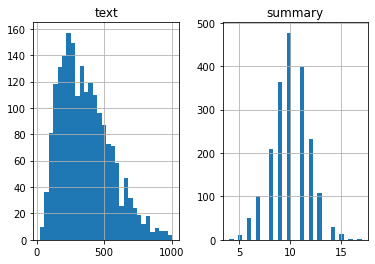

In [22]:

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_highlight']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [23]:
cnt=0
for i in data['cleaned_highlight']:
    if(len(i.split())<=14):
        cnt=cnt+1
print(cnt/len(data['cleaned_highlight']))

0.9919959979989995


In [24]:
max_text_len=300
max_summary_len=12

In [25]:
#convert text sequences into integer sequences
x_test_seq = x_tokenizer.texts_to_sequences(x_test) 



In [26]:
#padding zero upto maximum length
x_test = pad_sequences(x_test_seq,  maxlen=max_text_len, padding='post')



In [27]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.13038910359836
Total Coverage of rare words: 12.006825652323979


In [28]:
#convert text sequences into integer sequences
y_test_seq    =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_test    =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')


In [29]:
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
x_test=np.delete(x_test,ind, axis=0)

# Saving the data

In [30]:
np.save("../final_data/x_test.npy", x_test)
np.save("../final_data/y_test.npy", y_test)
